# Convex_Function

In [1]:
import numpy as np

a_array = np.arange(-1.5, 3, 0.01)
a_array = a_array.reshape(a_array.shape[0],1)

np.set_printoptions(formatter={'float': lambda x: "{0:0.2f}".format(x)})

In [289]:
import math
def get_objective(a):
    result = (-np.sin(3*a) - a**2 + 0.7*a)#-(a**2)
    return result

In [290]:
import math

accuracy_all=[]
a_ideal =0

for a in a_array:
    results = get_objective(a)
    accuracy_all.append(results)
    
accuracy_all= np.array(accuracy_all)

print(accuracy_all.shape)

print("Idea Values of a:",a_array[np.argmax(accuracy_all)],np.max(accuracy_all))

(450, 1)
Idea Values of a: [-0.36] 0.5003578068849475


# Plot of the exact  objective

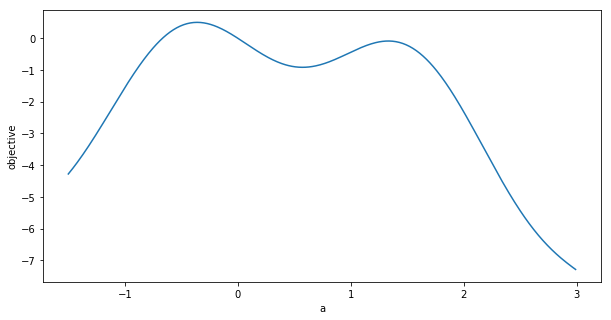

In [291]:
import matplotlib.pyplot as plt

def plot_exact_function():
    fig = plt.figure(figsize=(10,5))
    ax = fig.add_subplot(111)

    ax.plot(a_array, accuracy_all)

    ax.set_xlabel('a')
    ax.set_ylabel('objective')
    plt.show()

plot_exact_function()

# Initial Values for BL

In [369]:
a1 = 0.5
accuracy1 = get_objective(a1)
print('accuracy1 = ',accuracy1)

a2 = 0.7
accuracy2 = get_objective(a2)

print('accuracy2 = ',accuracy2)


X_init = np.array([[a1], [a2]])
Y_init= np.array([accuracy1, accuracy2])

Y_init = Y_init.reshape(Y_init.shape[0],1)

accuracy1 =  -0.8974949866040546
accuracy2 =  -0.8632093666488738


In [370]:
print(X_init.shape,Y_init.shape)

(2, 1) (2, 1)


In [371]:
# Domain Size = |D|
Domain_Size = a_array.shape[0]
print(Domain_Size)

450


# Plot the Gaussian Process predictions

In [406]:
def Plot_the_function_and_Exact_values(gpr,X_samples,Y_samples):
    
    fig = plt.figure(figsize=(15,8))
    
    ax = fig.add_subplot(1, 2, 1)
    accuracy_pred, sigma = gpr.predict(a_array, return_std=True)
    sigma = sigma.reshape(sigma.shape[0],1)
    accuracy_pred = accuracy_pred.reshape(accuracy_pred.shape[0],1)
    
    accuracy_pred1 = accuracy_pred +  5*sigma
    
    accuracy_pred2 = accuracy_pred - 5*sigma
    
    return_acc1 = np.max(accuracy_pred)    
    ax.plot(a_array, accuracy_pred,label='Surrogate function',lw=2)
    
    ax.fill_between(a_array.ravel(), 
                     accuracy_pred.ravel() + 1.96 * sigma.ravel(), 
                     accuracy_pred.ravel() - 1.96 * sigma.ravel(), 
                     alpha=0.1,label="uncertainity") 
    
    #plotting the samples
    ax.plot(X_samples, Y_samples, 'kx', mew=3, label='Samples')
    
    
    ax.plot(a_array, accuracy_all, 'y--', lw=2, label='Noise-free objective')
    
    plt.legend()
    plt.show()
    
    return return_acc1
    

    
from sklearn.cluster import KMeans
def Plot_the_function_and_cluster(gpr, X_samples,Y_samples,t):
    
    fig = plt.figure(figsize=(15,8))
    
    ax = fig.add_subplot(1, 2, 1)
    accuracy_pred, sigma = gpr.predict(a_array, return_std=True)
    sigma = sigma.reshape(sigma.shape[0],1)
    accuracy_pred = accuracy_pred.reshape(accuracy_pred.shape[0],1)
    
    alpha = 2*math.log(Domain_Size*(t)*(t)*math.pi*math.pi/(6*0.1))
    alpha = math.sqrt(alpha)
    
    Acquition= accuracy_pred + (alpha)*sigma 
    Value = accuracy_pred + (alpha)*sigma    
    x_index = np.argmax(Value)
    
    
    #plot the mean of GP
    ax.plot(a_array, accuracy_pred,label='Surrogate function',lw=2)
    
    #plot the Acquition function
    ax.plot(a_array, Acquition,label='Acquition function',lw=2)
    
    #plotting the samples
    ax.plot(X_samples, Y_samples, 'kx', mew=3, label='Samples')
    
    #plot the objective function
    ax.plot(a_array, accuracy_all, 'y--', lw=2, label='Noise-free objective')
    
    
    #first clustering on the basis of acquition function
    kmeans = KMeans(n_clusters=3, random_state=0).fit(Acquition)
    cluster_pred = kmeans.labels_.reshape(kmeans.labels_.shape[0])
    #print('cluster_pred',cluster_pred.size)
    x_plot = a_array.reshape(a_array.shape[0])
    Acquition = Acquition.reshape(Acquition.shape[0])
    
    #plot the clusters on Acquition function
    #ax.scatter(x_plot, Acquition, label='Clustersp',c=cluster_pred)
    
    
    #select the best cluster in the acquition function, and now cluster in the domain space itself
    acq_cluster_max_index = np.argmax(kmeans.cluster_centers_)
    
    #select the points in acq_cluster_max_index
    x_best_acq_domain =[]
    x_best_acq_value  = []
    
    for i in range(a_array.shape[0]):
        if cluster_pred[i]==acq_cluster_max_index:
            x_best_acq_domain.append(a_array[i])
            x_best_acq_value.append(Acquition[i])
    
    x_best_acq_domain= np.array(x_best_acq_domain)
    x_best_acq_value= np.array(x_best_acq_value)
    
    
    #plot the points in best cluster along with values
    #ax.scatter(x_best_acq_domain, x_best_acq_value, label='best cluster')
    
    #Do the domain space based clustering on the best points
    kmeans = KMeans(n_clusters=3, random_state=0).fit(x_best_acq_domain)
    cluster_pred_domain = kmeans.labels_.reshape(kmeans.labels_.shape[0])
    
    #plot the domain space based best cluster
    ax.scatter(x_best_acq_domain, x_best_acq_value, label='best acq domain clusters',c=cluster_pred_domain)
    
    #now select the centroid of the clustering in domain space
    cluster_centroid = kmeans.cluster_centers_.reshape(kmeans.cluster_centers_.shape[0])
    #print('cluster_centroid',cluster_centroid)
    
    #plot the cluster centroids
    #for i in range(cluster_centroid.shape[0]):
    #    ax.axvline(x=cluster_centroid[i], ls='--', c='k', lw=1)
    
    partitioned_space = dict()
    partitioned_acq = dict()
    for i in range(num_of_clusters):
        partitioned_space[i] = []
        partitioned_acq[i] = []
    
    for i in range(x_best_acq_domain.shape[0]):
        #print(cluster_pred_domain[i])
        partitioned_space[cluster_pred_domain[i]].append(x_best_acq_domain[i])
        partitioned_acq[cluster_pred_domain[i]].append(x_best_acq_value[i])
        
    
    batch = []
    #batch.append(a_array[x_index])
    
    for i in partitioned_space:
        x_local = partitioned_space[i]
        acq_local = partitioned_acq[i]
        acq_local = np.array(acq_local)
        x_index = np.argmax(acq_local)
        x_final_selected = x_local[x_index]
        batch.append(x_final_selected)
        
    batch = np.array(batch)
    
    for i in range(batch.shape[0]):
        ax.axvline(x=batch[i], ls='--', c='k', lw=1)
    
    plt.legend()
    plt.show()
    

# UCB

In [407]:
def Upper_Confidence_Bound(X, gpr,t):
    ''' Compute the upper confidence bound '''
    mu, sigma = gpr.predict(X, return_std=True)
    mu = mu.reshape(mu.shape[0],1)
    sigma = sigma.reshape(sigma.shape[0],1)
    
    alpha = 2*math.log(Domain_Size*(t)*(t)*math.pi*math.pi/(6*0.1))
    alpha = math.sqrt(alpha)
    
    Value = mu + (alpha)*sigma    
    x_index = np.argmax(Value)
    
    #print("alpha is:",alpha,np.max((alpha)*sigma))
    
    return X[x_index]

In [408]:
num_of_clusters = 3

def Upper_Confidence_Bound_Batch(X, gpr,t):
    ''' Compute the upper confidence bound '''
    mu, sigma = gpr.predict(X, return_std=True)
    mu = mu.reshape(mu.shape[0],1)
    sigma = sigma.reshape(sigma.shape[0],1)
    
    alpha = 2*math.log(Domain_Size*(t)*(t)*math.pi*math.pi/(6*0.1))
    alpha = math.sqrt(alpha)
    
    Value = mu + (alpha)*sigma    
    x_index = np.argmax(Value)
    
    
     
    #first clustering on the basis of acquition function
    Acquition = mu + (alpha)*sigma  
    kmeans = KMeans(n_clusters=3, random_state=0).fit(Acquition)
    cluster_pred = kmeans.labels_.reshape(kmeans.labels_.shape[0])
    x_plot = a_array.reshape(a_array.shape[0])
    Acquition = Acquition.reshape(Acquition.shape[0])
    
    #plot the clusters on Acquition function
    #ax.scatter(x_plot, Acquition, label='Clustersp',c=cluster_pred)
    
    
    #select the best cluster in the acquition function, and now cluster in the domain space itself
    acq_cluster_max_index = np.argmax(kmeans.cluster_centers_)
    
    #select the points in acq_cluster_max_index
    x_best_acq_domain =[]
    x_best_acq_value  = []
    
    for i in range(a_array.shape[0]):
        if cluster_pred[i]==acq_cluster_max_index:
            x_best_acq_domain.append(a_array[i])
            x_best_acq_value.append(Acquition[i])
    
    x_best_acq_domain= np.array(x_best_acq_domain)
    x_best_acq_value= np.array(x_best_acq_value)
    
    
    #plot the points in best cluster along with values
    #ax.scatter(x_best_acq_domain, x_best_acq_value, label='best cluster')
    
    #Do the domain space based clustering on the best points
    kmeans = KMeans(n_clusters=num_of_clusters, random_state=0).fit(x_best_acq_domain)
    cluster_pred_domain = kmeans.labels_.reshape(kmeans.labels_.shape[0])
    
    #plot the domain space based best cluster
    #ax.scatter(x_best_acq_domain, x_best_acq_value, label='best acq domain clusters',c=cluster_pred_domain)
    
    #now select the centroid of the clustering in domain space
    #cluster_centroid = kmeans.cluster_centers_.reshape(kmeans.cluster_centers_.shape[0])
    
    #partition the space into the cluster in X and select the best X from each space
    partitioned_space = dict()
    partitioned_acq = dict()
    for i in range(num_of_clusters):
        partitioned_space[i] = []
        partitioned_acq[i] = []
    
    for i in range(x_best_acq_domain.shape[0]):
        #print(cluster_pred_domain[i])
        partitioned_space[cluster_pred_domain[i]].append(x_best_acq_domain[i])
        partitioned_acq[cluster_pred_domain[i]].append(x_best_acq_value[i])
        
    
    batch = []
    #batch.append(X[x_index])
    
    for i in partitioned_space:
        x_local = partitioned_space[i]
        acq_local = partitioned_acq[i]
        acq_local = np.array(acq_local)
        x_index = np.argmax(acq_local)
        x_final_selected = x_local[x_index]
        batch.append(x_final_selected)
        
    batch = np.array(batch)
    
    
    return batch 

In [409]:
# from sklearn.cluster import KMeans
# import numpy as np
# X = np.array([[1, 2], [1, 4], [1, 0],
#               [10, 2], [10, 4], [10, 0]])
# kmeans = KMeans(n_clusters=2, random_state=0).fit(X)

# print(kmeans.labels_)

In [410]:
#print(kmeans.cluster_centers_)

In [411]:
X_matrix = a_array

In [412]:
# Functions from the Mango library 
from scipy.stats import uniform
from mango.domain.distribution import loguniform
from mango.domain.domain_space import domain_space


param_dict = {"a": uniform(-1.5, 4.5)}

ds = domain_space(param_dict,450)

# Bayesian learning Sequential Iterations

Starting GPR Assumption


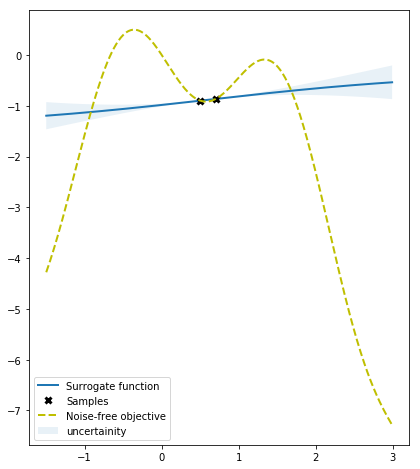

Iteration count: 1  Best results: -0.4079021517602657


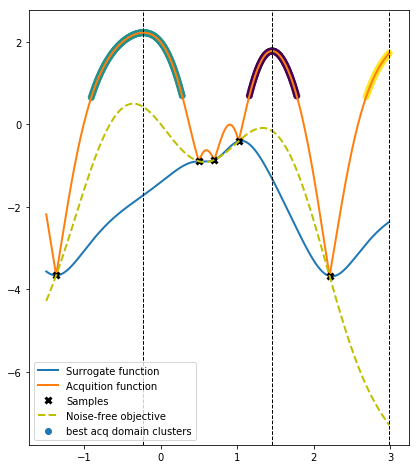

Iteration count: 2  Best results: -0.4079021517602657


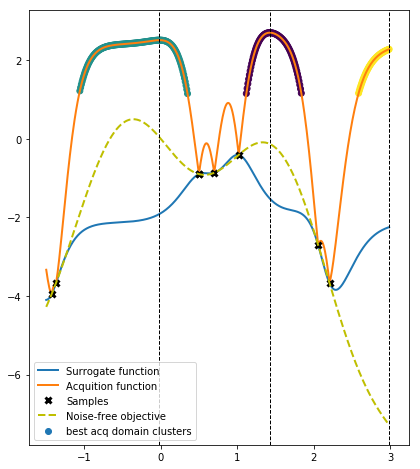

Iteration count: 3  Best results: -0.4079021517602657


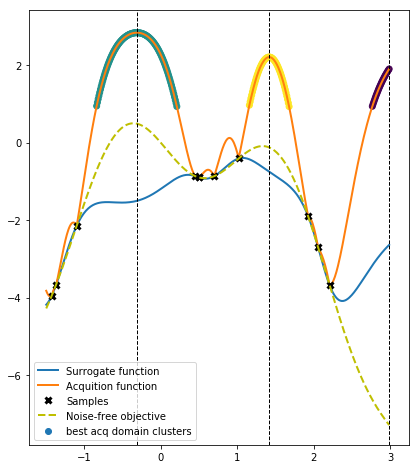

Iteration count: 4  Best results: 0.49279156830099785


/Users/sandeep/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:357: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


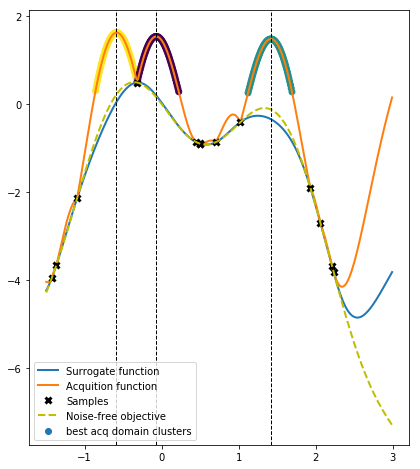

/Users/sandeep/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:357: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/Users/sandeep/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:480: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 52, 'nit': 5, 'warnflag': 2}
  ConvergenceWarning)
/Users/sandeep/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:357: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


Iteration count: 5  Best results: 0.49279156830099785


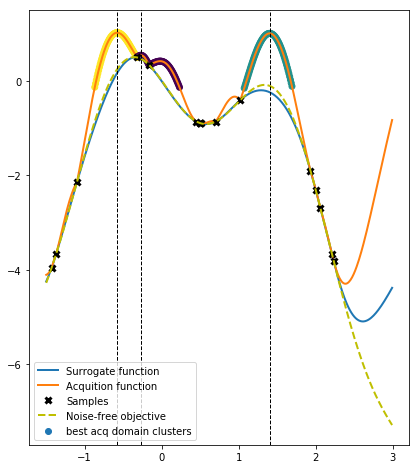

/Users/sandeep/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:357: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/Users/sandeep/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:357: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


Iteration count: 6  Best results: 0.49279156830099785


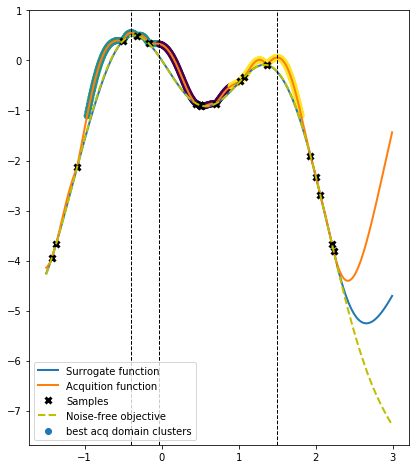

/Users/sandeep/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:357: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/Users/sandeep/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:357: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


Iteration count: 7  Best results: 0.49279156830099785


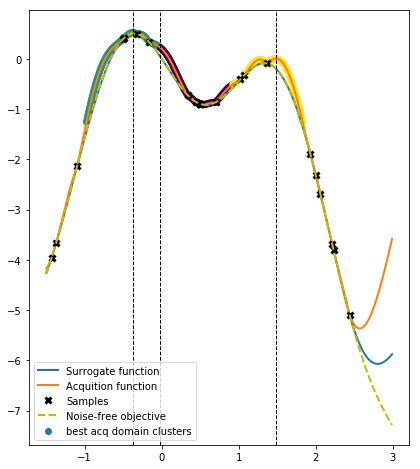

/Users/sandeep/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:357: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/Users/sandeep/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:480: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-20.64]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 21, 'nit': 0, 'warnflag': 2}
  ConvergenceWarning)
/Users/sandeep/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:357: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


Iteration count: 8  Best results: 0.49279156830099785


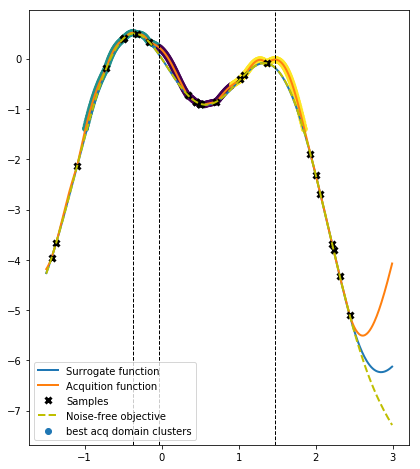

/Users/sandeep/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:357: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/Users/sandeep/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:480: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-23.80]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 21, 'nit': 0, 'warnflag': 2}
  ConvergenceWarning)
/Users/sandeep/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:357: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


Iteration count: 9  Best results: 0.49279156830099785


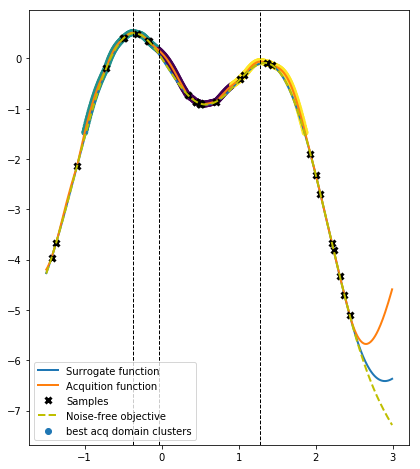

/Users/sandeep/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:357: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/Users/sandeep/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:480: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-8.46]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 21, 'nit': 0, 'warnflag': 2}
  ConvergenceWarning)
/Users/sandeep/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:480: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-27.27]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 21, 'nit': 0, 'warnflag': 2}
  ConvergenceWarning)
/Users/sandeep/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:357: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("P

Iteration count: 10  Best results: 0.49279156830099785


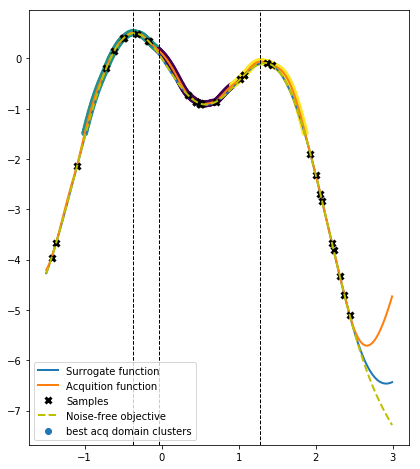

In [413]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, Matern
noise = 0.01

# Gaussian process with Matern kernel as surrogate model
gpr = GaussianProcessRegressor(kernel=Matern(nu=2.5),n_restarts_optimizer=10,random_state =1 ,normalize_y=True)


# Number of iterations
n_iter = 10

X_sample = X_init
Y_sample = Y_init
gpr.fit(X_sample, Y_sample)

#Printing the starting assumption
print('Starting GPR Assumption')
Plot_the_function_and_Exact_values(gpr,X_sample,Y_sample)

for i in range(n_iter):
    
    
    domain_list = ds.get_domain()
    X_domain_np = ds.convert_GP_space(domain_list)
        
    curr_sample_batch = Upper_Confidence_Bound_Batch(X_domain_np,gpr,i+1)
    results = get_objective(curr_sample_batch)
    #print(curr_sample_batch,results)
    
    curr_sample_batch = curr_sample_batch.reshape(curr_sample_batch.shape[0],1)
    results = results.reshape(results.shape[0],1)
    
    X_sample = np.vstack((X_sample, curr_sample_batch))
    Y_sample = np.vstack((Y_sample, results))
    
    print('Iteration count:',i+1,' Best results:',np.max(Y_sample))
    
    gpr.fit(X_sample, Y_sample)
    Plot_the_function_and_cluster(gpr,X_sample,Y_sample,i+1)
    

# Scatter Plot

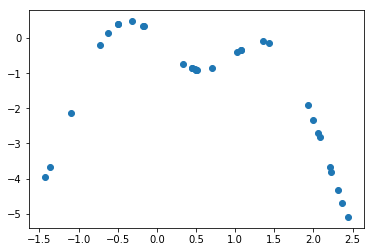

In [414]:
import matplotlib.pyplot as plt

fig = plt.figure()

plt.scatter(X_sample[:,0], Y_sample, marker='o')

plt.show()